# Structured Names
This notebook describes how to use structured names to check SBML models for moiety balance.

In [1]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions
from SBMLLint.common.simple_sbml import SimpleSBML

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

In [2]:
from SBMLLint.common.simple_sbml import modelIterator

In [3]:
iterator = modelIterator(initial=19, final=25)
for item in iterator:
    print(item.filename)

BIOMD0000000241_url.xml
BIOMD0000000350_url.xml
MODEL0847712949_url.xml
BIOMD0000000346_url.xml
BIOMD0000000256_url.xml
BIOMD0000000402_url.xml


In [4]:
import init
from SBMLLint.tools import sbmllint

# The first step in glycolysis, expressed
# in the Antimony language.
model = """
Glu + A__P_3 -> Glu_P + A_P_P; 1
Glu = 0
A_P_P_P = 0
Glu_P = 0
A_P_P = 0
"""
_ = sbmllint.lint(model)


0 of 1 reactions have imbalances.



In [5]:
# The first step in glycolysis, with an error (wrongly goes to A instead of A_P_P)
model = """
Glu + A_P_P_P -> Glu_P + A_P; 1
"""
_ = sbmllint.lint(model)


1 of 1 reactions have imbalances.

***_J0: Glu + A_P_P_P -> Glu_P + A_P
Excess moieties in reactants
  P: 1.00




In [7]:
cn.ANALYSIS_STRUCTURED_NAMES_DIR

'/home/ubuntu/SBMLLint/analysis/structured_names'

## Sturctured Names in BioModels

In [8]:
path = os.path.join(cn.ANALYSIS_STRUCTURED_NAMES_DIR, "analyze_structured_names.csv")
df_data = pd.read_csv(path)
df_data.head()

,filename,is_structured,num_boundary_reactions,total_reactions,num_imbalanced_reactions,num_balanced_reactions,frac_balanced_reactions,frac_Boundary_reactions
0,BIOMD0000000100_url.xml,False,5,10,10,0,0.0,0.500000
1,BIOMD0000000355_url.xml,True,12,17,17,0,0.0,0.705882
2,BIOMD0000000413_url.xml,False,4,9,9,0,0.0,0.444444
3,BIOMD0000000594_url.xml,True,0,120,120,0,0.0,0.000000
4,BIOMD0000000354_url.xml,False,6,11,11,0,0.0,0.545455


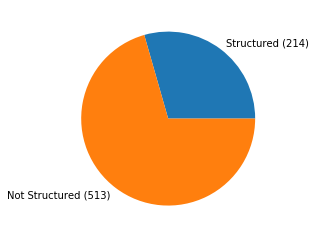

In [9]:
# Basic Statistics
num_structured = len(df_data[df_data[cn.IS_STRUCTURED]])
num_not_structured = len(df_data) - num_structured
_ = plt.pie([num_structured, num_not_structured], 
            labels=["Structured (%d)" % num_structured, "Not Structured (%d)" % num_not_structured])

Text(0, 0.5, 'Fraction of Models')

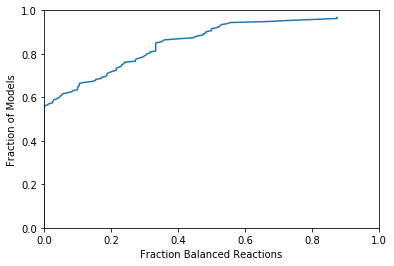

In [10]:
df_sort = df_data[df_data[cn.IS_STRUCTURED]]
df_sort = df_sort.sort_values(cn.FRAC_BALANCED_REACTIONS)
df_sort = df_sort.reset_index()
yv = [1.0*i/len(df_sort) for i in df_sort.index]
_ = plt.plot(df_sort[cn.FRAC_BALANCED_REACTIONS], yv)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Fraction Balanced Reactions")
plt.ylabel("Fraction of Models")

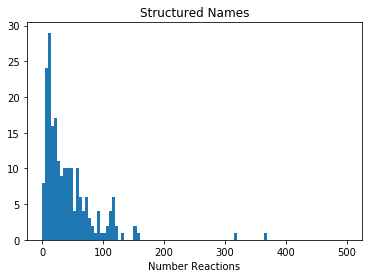

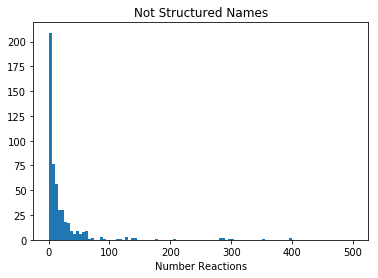

In [11]:
def plotIsStructured(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.hist(df1[cn.TOTAL_REACTIONS], bins=100, range=(0, 500))
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.show()
plotIsStructured(df_data, True)
plotIsStructured(df_data, False)

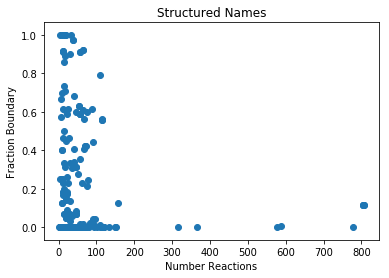

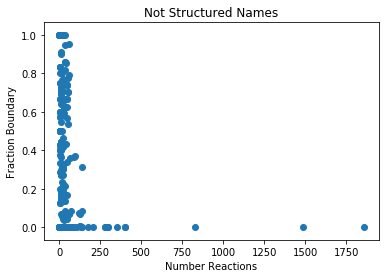

In [12]:
def plotFrcBoundary(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.scatter(df1[cn.TOTAL_REACTIONS], df1[cn.FRAC_BOUNDARY_REACTIONS])
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.ylabel("Fraction Boundary")
    plt.show()
plotFrcBoundary(df_data, True)
plotFrcBoundary(df_data, False)

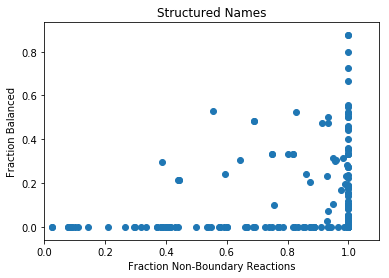

In [13]:
def plotFracBalanced(df):
    df1 = df[df[cn.IS_STRUCTURED]]
    xv = (1.0*df1[cn.TOTAL_REACTIONS] - df1[cn.NUM_BOUNDARY_REACTIONS]) / df1[cn.TOTAL_REACTIONS]
    plt.scatter(xv, df1[cn.FRAC_BALANCED_REACTIONS])
    title = "Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Non-Boundary Reactions")
    plt.ylabel("Fraction Balanced")
    plt.xlim([0, 1.1])
    plt.show()
plotFracBalanced(df_data)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



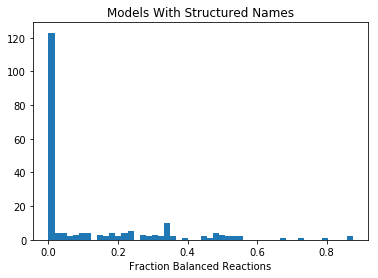

In [14]:
# Histogram of fraction balanced for structured names
def plotFracBalancedHist(df):
    df1 = df[df[cn.IS_STRUCTURED]]
    plt.hist(df1[cn.FRAC_BALANCED_REACTIONS], bins=50)
    title = "Models With Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Balanced Reactions")
    plt.show()
plotFracBalancedHist(df_data)

## Detailed Look at Putative Structured Names

**Observations**
1. Some cases where doing ad hoc structured names that with little change can balance. For example:   
   1. BIOMD0000000192_url.xml: RCC1_RanGDP -> RCC1_Ran + GDP, RCC1_Ran + GTP -> RCC1_RanGTP
   1. BIOMD0000000010_url.xml: MKKK -> MKKK_P, MKKK_P -> MKKK

In [16]:
df = df_data[df_data[cn.IS_STRUCTURED]]
for _, row in df.iterrows():
    path = os.path.join(cn.BIOMODELS_DIR, row[cn.FILENAME])
    print("\n%s" % row[cn.FILENAME])
    print_reactions.prettyPrint(path, is_include_kinetics=False, is_include_label=False)


BIOMD0000000355_url.xml
 -> IP3
CaI -> CaS
CaS -> CaI
IP3 -> 
 -> g
g -> 
 -> CaI
CaI -> 
 -> mwaf195932_a72c_4552_8cf2_b349b15d39c4
mwaf195932_a72c_4552_8cf2_b349b15d39c4 -> 
 -> mw0ebc76ad_49d7_4845_8f88_04d443fbe7f3
 -> mw7cb2644a_384a_4bbb_93fd_fd686e01d7cb
mw7cb2644a_384a_4bbb_93fd_fd686e01d7cb -> 
mw0ebc76ad_49d7_4845_8f88_04d443fbe7f3 -> 
CaI -> mw013a7c64_a9ec_483c_b3b8_ed658337ee95
CaS -> mw013a7c64_a9ec_483c_b3b8_ed658337ee95
mw013a7c64_a9ec_483c_b3b8_ed658337ee95 -> CaI

BIOMD0000000594_url.xml
EGFR_10UU -> EGFR_00UU
EGFR_01UU -> EGFR_00UU
EGFR_11UU -> EGFR_01UU
EGFR_11UU -> EGFR_10UU
EGFR_11CU -> EGFR_10CU
EGFR_11LU -> EGFR_10LU
EGFR_11UG -> EGFR_01UG
EGFR_11UL -> EGFR_01UL
EGFR_02UU -> EGFR_01UU
EGFR_02UG -> EGFR_01UG
EGFR_02UL -> EGFR_01UL
EGFR_12UU -> EGFR_02UU
EGFR_12UU -> EGFR_11UU
EGFR_12CU -> EGFR_11CU
EGFR_12LU -> EGFR_11LU
EGFR_12UG -> EGFR_02UG
EGFR_12UG -> EGFR_11UG
EGFR_12UL -> EGFR_02UL
EGFR_12UL -> EGFR_11UL
EGFR_12CG -> EGFR_11CG
EGFR_12CC -> EGFR_11CC
EGFR_

DNA_001 + S1 -> DNA_101
DNA_001 + S1 -> DNA_011
DNA_110 + S1 -> DNA_111
DNA_101 + S1 -> DNA_111
DNA_011 + S1 -> DNA_111
DNA_110 -> DNA_1B10
DNA_011 -> DNA_01B1
DNA_111 -> DNA_11B1
DNA_111 -> DNA_1B11
DNA_11B1 -> DNA_1B1B1
DNA_1B11 -> DNA_1B1B1

BIOMD0000000598_url.xml
 -> cL_m
cL_m -> 
 -> cL
cL -> 
 -> cLm
cLm -> 
 -> cP
cP -> 
 -> cP9_m
cP9_m -> 
 -> cP9
cP9 -> 
 -> cP7_m
cP7_m -> 
 -> cP7
cP7 -> 
 -> cNI_m
cNI_m -> 
 -> cNI
cNI -> 
 -> cT_m
cT_m -> 
 -> cT
cT -> 
 -> cE4_m
cE4_m -> 
 -> cE4
cE4 -> 
 -> cE3_m
cE3_m -> 
 -> cE3
cE3 -> 
cE3 -> cE3n
cE3n -> 
 -> cLUX_m
cLUX_m -> 
 -> cLUX
cLUX -> 
 -> cCOP1c
cCOP1c -> 
cCOP1c -> cCOP1n
cCOP1n -> 
cCOP1n -> cCOP1d
cCOP1d -> 
 -> cG_m
cG_m -> 
 -> cG
cG -> 
cG + cZTL -> cZG
 -> cZTL
cZTL -> 
cZG -> 
cE3 + cG -> cEG
cEG -> 
 -> cEC
cEC -> 

BIOMD0000000236_url.xml
GLC -> G6P_F6P
G6P_F6P -> FBP
FBP -> 2.00 DHAP_G3P
DHAP_G3P -> 

BIOMD0000000090_url.xml
sul_ex -> sul
eth_ex -> eth
sul + A3c -> aps + PPi
oxy_ex -> oxy
oxy -> oxy_ex
aps + A3c 

 -> M_P
 -> M_T
M_T -> 
M_P -> 
 -> P0
 -> T0
P0 -> 
P1 -> 
P2 -> 
T0 -> 
T1 -> 
T2 -> 
P2 + T2 -> C
C -> 
CN -> 
C -> CN
P0 -> P1
P1 -> P2
P1 -> P0
P2 -> P1
T0 -> T1
T1 -> T2
T1 -> T0
T2 -> T1
T2 -> 
P2 -> 

BIOMD0000000536_url.xml
mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc + mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> mw03db56ac_8dc6_4931_ae82_fef706d2ee3d
mw03db56ac_8dc6_4931_ae82_fef706d2ee3d + mwbbbce920_e8dd_4320_9386_fc94bfb2fc99 -> mw810ff751_fa4e_4143_bd50_169b3e325e1e
 -> mwf626e95e_543f_41e4_aad4_c6bf60ab345b
mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> 
mw114aa90f_5f5b_4fe8_9406_361c8489b6a1 -> 
mw4638f126_8cb8_4021_ab41_6ae195743ba0 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mw10315fa3_6f13_4618_bda8_a8694bd3c374 + mw0adf3eb4_a196_4c48_b10d_4e9e9faaf9e1 -> mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83
mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mwd2d9d93a_3bd1_4f17_bac1_ba

 -> AA_b
AA_b -> 
 -> HPETE_b
HPETE_b -> HETE_b
HPETE_b -> HETE_b
 -> LTA4_b
LTA4_b -> LTC4_b
HETE_b -> 
LTA4_b -> 
LTC4_b -> 
 -> LTC4_b_out
LTC4_b_out -> LTD4_b
LTD4_b -> LTE4_b
LTC4_b_out -> 
LTD4_b -> 
LTE4_b -> 
EO_b -> EO_i_b
EO_i_b -> EO_a_b
EO_a_b -> EO_b
EO_b -> 
EO_a_b -> 
EO_i_b -> EO_i_aw
EO_a_b -> EO_a_aw
EO_b -> EO_aw
 -> Hn_b
Hn_b -> 
 -> IL_b
IL_b -> 
IL_b -> IL_bm
 -> EO_bm
EO_bm -> EO_b
 -> AA_aw
AA_aw -> 
 -> HPETE_aw
HPETE_aw -> HETE_aw
HPETE_aw -> HETE_aw
 -> LTA4_aw
LTA4_aw -> LTC4_aw
HETE_aw -> 
LTA4_aw -> 
LTC4_aw -> 
 -> LTC4_aw_out
LTC4_aw_out -> LTD4_aw
LTD4_aw -> LTE4_aw
LTE4_aw -> LTE4_b
LTD4_aw -> LTD4_b
LTC4_aw_out -> LTC4_b_out
EO_aw -> EO_i_aw
EO_i_aw -> EO_a_aw
EO_a_aw -> EO_aw
EO_aw -> 
EO_a_aw -> 
 -> Hn_aw
Hn_aw -> Hn_b
 -> IL_aw
IL_aw -> IL_b
LTE4_aw -> 
LTD4_aw -> 
LTC4_aw_out -> 
IL_aw -> 
Hn_aw -> 
ZF_intes -> ZF_blood
ZF_blood -> ZF_airways
ZF_blood -> 
ML_intes -> ML_blood
ML_blood -> 

BIOMD0000000412_url.xml
s1 -> cL_m
cL_m -> s2
s3 -> cL
cL

time -> T
frq_gene -> frq_mRNA
wc1_gene -> wc1_mRNA
wc2_gene -> wc2_mRNA
vvd_gene -> vvd_mRNA
frq_mRNA -> hypoFRQc
wc1_mRNA -> WC1c
wc2_mRNA -> WC2c
vvd_mRNA -> VVDc
frq_mRNA -> degraded_frq_mRNA
wc1_mRNA -> degraded_wc1_mRNA
wc2_mRNA -> degraded_wc2_mRNA
vvd_mRNA -> degraded_vvd_mRNA
WC1c + WC2c -> hypoWCCc
hypoFRQc -> hypoFRQn
hypoWCCc -> hypoWCCn
VVDc -> VVDn
hypoFRQn -> hypoFRQc
hyperFRQn -> hyperFRQc
hyperWCCn -> hyperWCCc
hypoFRQc -> hyperFRQc
hypoFRQn -> hyperFRQn
hypoWCCc -> hyperWCCc
hypoWCCn -> hyperWCCn
hyperWCCc -> hypoWCCc
hypoWCCn -> active_hypoWCCn
hypoWCCn -> L_WCC
VVDn + L_WCC -> L_WCCVVDn
L_WCCVVDn -> hypoWCCn + VVDn
hyperFRQc -> degraded_hyperFRQc
hyperFRQn -> degraded_hyperFFCn
WC1c -> degraded_WC1c
WC2c -> degraded_WC2c
hyperWCCc -> degraded_hyperWCCc
hyperWCCn -> degraded_hyperWCCn
active_hypoWCCn -> degraded_active_hypoWCCn
L_WCC -> degraded_L_WCCCVVDn
VVDc -> degraded_VVDc
VVDn -> degraded_VVDn
L_WCCVVDn -> degraded_L_WCCCVVDn

MODEL0404023805_url.xml
R_cw0 -> R

ValueError: Errors in SBML document


In [ ]:
simple = SimpleSBML()
path = os.path.join(cn.DATA_DIR, "BIOMD0000000353_url.xml")
simple.initialize(path)

**To Do**
1. Identify the missing files. Likely a problem with the iterator?